In [1]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import matplotlib.pyplot as plt
from statsmodels.stats import multitest
from scipy import stats
from bahc import filterCovariance
from utils import LouvainCorrelationClustering
from upload_data import upload_clean_data
from market_state_strategy import market_state_strategy, market_state_strat_upgraded, strat_eval, med_HL, FDR, _cal_w, number_of_states


In [2]:
def market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure='med', seed=10): #matrix of log returns
    np.random.seed(seed)
    T=int(np.floor(r.shape[1]/3))
    pos = pd.DataFrame(0.0, index=r.index, columns=r.columns)
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]
        if my_list:
            if trend_measure=='med_HL':
                ar=med_HL(R.iloc[my_list])
            elif trend_measure=='med':
                ar=R.iloc[my_list].median(axis=0)
            else:
                ar=R.iloc[my_list].mean(axis=0)
            e = np.sign(ar.values)
            if opt:
                w=_cal_w(R, e, is_BAHC)
            else:
                w = e/r.shape[1]
            pos.iloc[t+1] = w
    return pos 


# clusters by minutes

#2007-2008

In [7]:
filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-2008-vwap-trade-1min.parquet"
all=pd.read_parquet(filepath)

all.replace(0, np.nan, inplace=True)
non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
all_filtered.index = pd.to_datetime(all_filtered.index)
all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)
all_fill = all_filtered.ffill()

lin_ret78=all_fill.pct_change()
rows_with_null = lin_ret78[lin_ret78.isnull().any(axis=1)]
lin_ret78 = lin_ret78.loc[rows_with_null.index[-1]:]


In [ ]:
T=int(np.floor(lin_ret78.shape[1]/3))
x=lin_ret78.iloc[1000:1000+T-1].T # N by T

original=x.T.corr()
filtered_matrix = filterCovariance(x.values, is_correlation=True) 
    
f = plt.figure(figsize=(12, 4), dpi=200)
ax = plt.subplot(121)
ax.imshow(original, cmap='seismic', vmin=-1, vmax=1, origin='lower')
plt.title("Original",fontsize=18)
ax = plt.subplot(122)
plt.title("Filtered",fontsize=18)
a = ax.imshow(filtered_matrix, cmap='seismic', vmin=-1, vmax=1, origin='lower')
cbar = f.colorbar(a, ticks=[-1, 0, 1])
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

im1 = axs[0].imshow(original, cmap='seismic', vmin=-1, vmax=1, origin='lower')
axs[0].set_title("Original")

im2 = axs[1].imshow(filtered_matrix, cmap='seismic', vmin=-1, vmax=1, origin='lower')
axs[1].set_title("BCHA Filtering")

cbar1 = fig.colorbar(im1, ax=axs[0], ticks=[-1, -0.75, -0.5, -0.25, 0.00, 0.25, 0.50, 0.75, 1])
cbar2 = fig.colorbar(im2, ax=axs[1], ticks=[-1, -0.75, -0.5, -0.25, 0.00, 0.25, 0.50, 0.75, 1])

plt.show()

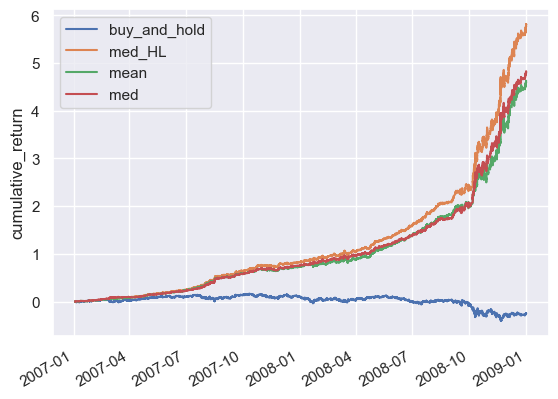

In [12]:
import seaborn as sns
sns.set()

r=lin_ret78.copy()
T=int(np.floor(r.shape[1]/3))
M=['med_HL', 'mean', 'med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
cr=strat_eval(pos, r, Strat_Name='buy_and_hold')

# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    _=strat_eval(pos, r, Strat_Name=m)

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=False, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_no_filter')

# for m in M:
#     pos=market_state_strat_upgraded(r, opt=True, is_BAHC=True, trend_measure=m)
#     strat_eval(pos, r, Strat_Name=m+'_MPV_BAHC')

plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()


# 2007 linear ret

In [6]:
all_fill = all_filtered.ffill()
rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
all_fill = all_fill.loc[rows_with_null.index[-1]+1:]
lin_ret=all_fill.pct_change()

lin_ret.loc['2007-01-04']

vwap                                          \
ticker                   AA.N     ABT.N     AEP.N     AVP.N     AXP.N   
minute                                                                  
2007-01-04 14:31:00  0.002703  0.000885  0.000000  0.000000  0.000000   
2007-01-04 14:32:00 -0.001919  0.004371  0.000000 -0.000430  0.000000   
2007-01-04 14:33:00 -0.000345 -0.000052  0.000000  0.000350  0.000000   
2007-01-04 14:34:00 -0.001670 -0.002560 -0.001170  0.000000  0.000000   
2007-01-04 14:35:00  0.000663  0.000012  0.000377  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2007-01-04 20:56:00  0.000192 -0.000200 -0.000149  0.000226  0.000062   
2007-01-04 20:57:00 -0.000226  0.000575 -0.000193  0.000852 -0.000280   
2007-01-04 20:58:00  0.000102 -0.000786 -0.000014 -0.000379 -0.000614   
2007-01-04 20:59:00 -0.000336  0.000047  0.000085 -0.000502  0.000563   
2007-01-04 21:00:00 -0.000437 -0.000415 -0.000303 -0.000240 -0.000144   

                                                                       ...  \
ticker                   BA.N     BAC.N     BAX.N     BHI.N      BK.N  ...   
minute                                                                 ...   
2007-01-04 14:31:00  0.000000  0.000191  0.000035 -0.005196  0.000000  ...   
2007-01-04 14:32:00  0.000000  0.001304 -0.000491  0.001508  0.000097  ...   
2007-01-04 14:33:00  0.000000  0.000090  0.000492 -0.002384 -0.001748  ...   
2007-01-04 14:34:00 -0.000378 -0.002326  0.001173 -0.002534 -0.003959  ...   
2007-01-04 14:35:00  0.000378 -0.000530  0.001197 -0.000832 -0.001238  ...   
...                       ...       ...       ...       ...       ...  ...   
2007-01-04 20:56:00 -0.000020 -0.000231  0.000014  0.000364 -0.000459  ...   
2007-01-04 20:57:00 -0.000584 -0.000304  0.000319 -0.000116  0.000233  ...   
2007-01-04 20:58:00 -0.000295 -0.000337 -0.000299 -0.000377 -0.000797  ...   
2007-01-04 20:59:00  0.000300  0.000237 -0.001165 -0.000641  0.000657  ...   
2007-01-04 21:00:00  0.000180 -0.000098 -0.000292 -0.000670 -0.000355  ...   

                                                                       \
ticker                  USB.N     UTX.N      VZ.N     WAG.N     WFC.N   
minute                                                                  
2007-01-04 14:31:00  0.000641 -0.002655  0.000000 -0.005116 -0.001235   
2007-01-04 14:32:00 -0.000490  0.003368  0.005977  0.002166  0.004504   
2007-01-04 14:33:00 -0.001280 -0.000408 -0.000196 -0.001068  0.000668   
2007-01-04 14:34:00 -0.001214 -0.000900  0.000227 -0.000657 -0.005608   
2007-01-04 14:35:00 -0.001721 -0.000825  0.000160  0.000205 -0.001657   
...                       ...       ...       ...       ...       ...   
2007-01-04 20:56:00  0.000075 -0.000241  0.000218  0.000002 -0.000816   
2007-01-04 20:57:00 -0.000140 -0.000072 -0.000212  0.000313  0.000053   
2007-01-04 20:58:00  0.000093 -0.000176  0.000175 -0.000033 -0.000070   
2007-01-04 20:59:00 -0.000032  0.000546  0.000049 -0.000055 -0.000081   
2007-01-04 21:00:00 -0.000179  0.000230 -0.000036 -0.000008  0.000028   

                                                                       
ticker                  WMB.N     WMT.N      WY.N     XOM.N     XRX.N  
minute                                                                 
2007-01-04 14:31:00  0.000283  0.000691  0.000000  0.000000  0.000582  
2007-01-04 14:32:00 -0.001412 -0.000768  0.000000  0.000000 -0.001891  
2007-01-04 14:33:00  0.002293 -0.000809 -0.004485 -0.008446 -0.001967  
2007-01-04 14:34:00 -0.002721 -0.001448 -0.001805 -0.001379 -0.002440  
2007-01-04 14:35:00 -0.000956 -0.000901 -0.000595 -0.001716 -0.000718  
...                       ...       ...       ...       ...       ...  
2007-01-04 20:56:00 -0.001115 -0.000290 -0.000187  0.000571 -0.000266  
2007-01-04 20:57:00 -0.001354 -0.000557 -0.000173  0.000538  0.000148  
2007-01-04 20:58:00 -0.000290 -0.000228 -0.000015 -0.000337 -0.000217  
2007-01-04 20:59:00  0

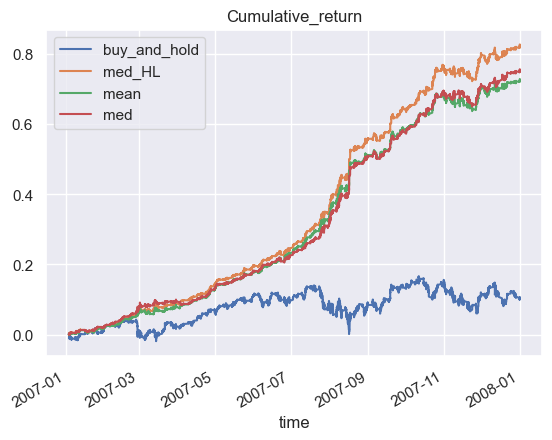

In [15]:
import seaborn as sns
sns.set()

r=lin_ret.copy()
# r=lin_ret.iloc[:100]
T=int(np.floor(r.shape[1]/3))
M=['med_HL', 'mean', 'med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
mr=strat_eval(pos, r, Strat_Name='buy_and_hold')

# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    strat_eval(pos, r, Strat_Name=m)


plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

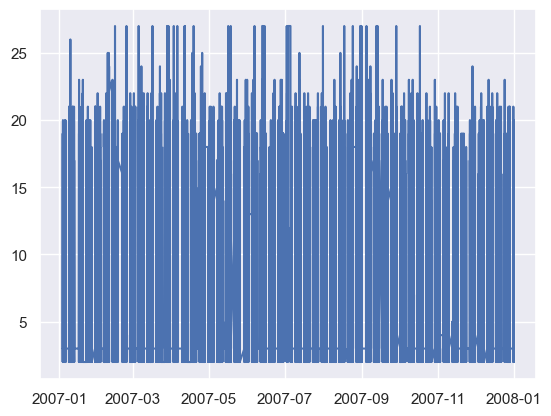

In [19]:
def number_of_states(r):
    Num=[]
    T=int(np.floor(r.shape[1]/3))
    for t in range(T,r.shape[0]-1):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        Num.append(DF[0].nunique())
    return Num

Num=number_of_states(r)
plt.plot(r.iloc[T:r.shape[0]-1].index,Num)

Text(0, 0.5, 'Number of Market states')

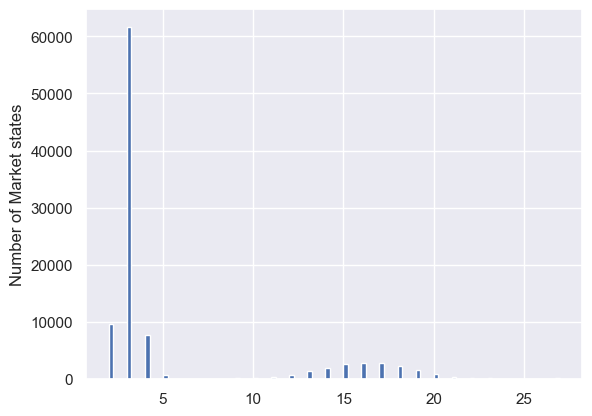

In [53]:
k=[num for num in Num if num > 22]
plt.hist(Num, bins=100)
plt.ylabel('Number of Market states')

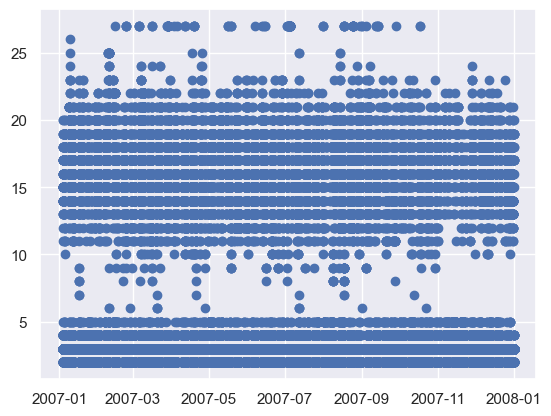

In [37]:
plt.scatter(r.iloc[T:r.shape[0]-1].index,Num, marker='o')

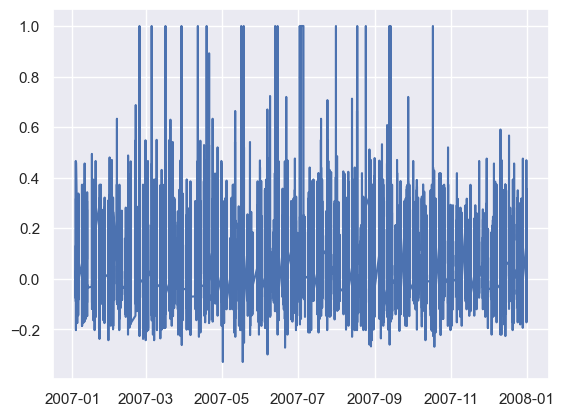

In [41]:
#ARI
from sklearn.metrics import adjusted_rand_score
ari=[]
T=int(np.floor(r.shape[1]/3))    
for t in range(T,r.shape[0]-2): 
    R1 = r.iloc[t-T+1:t+1]
    R2 = r.iloc[t-T+2:t+2]
    DF1 = LouvainCorrelationClustering(R1.T)
    DF2 = LouvainCorrelationClustering(R2.T)
    ari.append(adjusted_rand_score(DF1[0], DF2[0]))

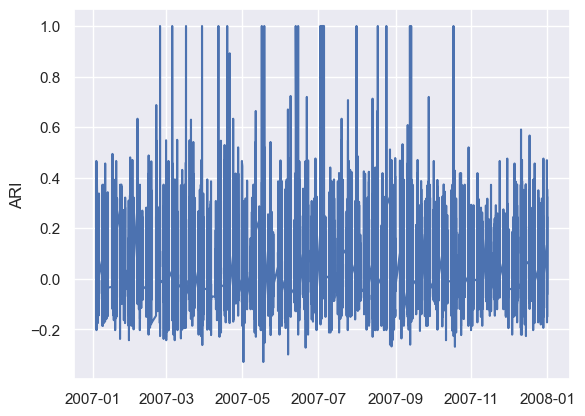

In [50]:
plt.plot(r.iloc[T:r.shape[0]-2].index,ari)
plt.ylabel('ARI')
plt.show()

Text(0.5, 0, 'ARI')

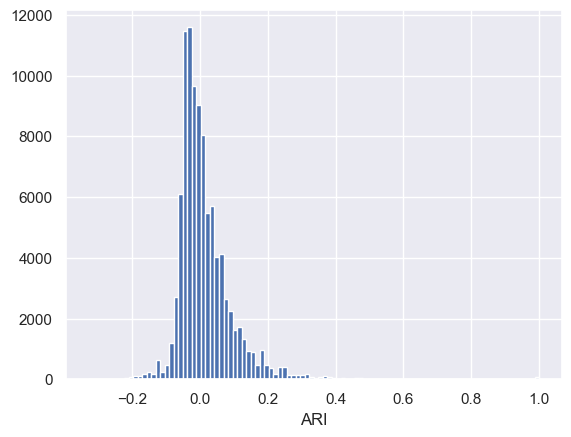

In [51]:

plt.hist(ari, bins=100)
plt.xlabel('ARI')

# 2010

In [84]:
filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\SP500-2010.parquet"
all=pd.read_parquet(filepath)

In [85]:
all.set_index('index', inplace=True)
all.replace(0, np.nan, inplace=True)
non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
all_fill = all_filtered.ffill()
lin_ret2010=all_fill.pct_change()
max_values_per_column=lin_ret2010.max(axis=0)
columns_greater_than_1 = max_values_per_column[max_values_per_column > 1].index
lin_ret2010 = lin_ret2010.drop(columns=columns_greater_than_1)


In [ ]:
import seaborn as sns
sns.set()

first_three_months = lin_ret2010[(lin_ret2010.index >= '2010-01-01') & (lin_ret2010.index < '2010-04-01')]
r=first_three_months
T=int(np.floor(r.shape[1]/3))
M=['med']

# buy and hold
pos= pd.DataFrame(0.0, index=r.index, columns=r.columns)
pos.iloc[T+1:]=1/r.shape[1]
cr=strat_eval(pos, r, Strat_Name='buy_and_hold')


# market state strategy
pos_list=[pos]
for m in M:
    pos=market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure=m)
    pos_list.append(pos)
    _=strat_eval(pos, r, Strat_Name=m)

plt.xlabel('')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

# Simulate with last bid ask price

In [72]:
import tqdm
def market_state_strat_upgraded(r, opt=False, is_BAHC=False, trend_measure='med', seed=10): #matrix of log returns
    np.random.seed(seed)
    T=int(np.floor(r.shape[1]/3))
    pos = pd.DataFrame(0.0, index=r.index, columns=r.columns)
    for t in tqdm.tqdm(range(T,r.shape[0]-1)):
        R = r.iloc[t-T+1:t+1]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]
        if my_list:
            if trend_measure=='med_HL':
                ar=med_HL(R.iloc[my_list])
            elif trend_measure=='med':
                ar=R.iloc[my_list].median(axis=0)
            else:
                ar=R.iloc[my_list].mean(axis=0)
            e = np.sign(ar.values)
            if opt:
                w=_cal_w(R, e, is_BAHC)
            else:
                w = e/r.shape[1]
            pos.iloc[t+1] = w
    return pos #all_ret

def strat_eval_bbo(pos, r_bid, r_ask, Strat_Name):
    T=int(np.floor(r_bid.shape[1]/3))
    df=pos.iloc[T:]
    buy = df.clip(lower=0)
    sell = df.clip(upper=0)
    
    model_returns=buy*r_ask.iloc[T:]+sell*r_bid.iloc[T:]
    total_returns=model_returns.sum(axis=1)
    cum_perf=total_returns+1
    cum_return=cum_perf.cumprod()-1
    cum_return.plot(label=Strat_Name)
    return cum_perf

def strat_eval(pos, r, Strat_Name):
    T=int(np.floor(r.shape[1]/3))
    model_returns=pos.iloc[T:]*r.iloc[T:]
    total_returns=model_returns.sum(axis=1)
    cum_perf=total_returns+1
    cum_return=cum_perf.cumprod()-1
    cum_return.plot(label=Strat_Name)
    return cum_return

Note: The times are given in UTC+00 and not the US time: UTC+5:00 (therefor the trading hours range from 14:00 )

In [18]:
filepath_vwap=r'data/clean/final/2007-2008-vwap-trade-1min.parquet'
allvwap=pd.read_parquet(filepath_vwap)
non_null_counts = allvwap.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = allvwap[selected_columns]
all_fill = all_filtered.ffill()
rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
all_fill = all_fill.loc[rows_with_null.index[-1]+pd.Timedelta(minutes=1):]
ret_vwap=all_fill.pct_change()

2007-01-03 14:30:00


In [64]:
filepath_bbo=r"data/clean/final/2007-2008_bbolast.parquet"
all_data=pd.read_parquet(filepath_bbo)
all=all_data.set_index(['minute','ticker']).unstack(level='ticker')
all.index = pd.to_datetime(all.index)
all.replace(0, np.nan, inplace=True)
print(all.index[0])
all_bid=all['bid_last']
all_ask=all['ask_last']

def data_preprocess(all):
    non_null_counts = all.count()
    selected_columns = non_null_counts[non_null_counts > 90000].index
    all_filtered = all[selected_columns]
    all_fill = all_filtered.ffill()
    rows_with_null = all_fill[all_fill.isnull().any(axis=1)]
    all_fill = all_fill.loc[rows_with_null.index[-1]+pd.Timedelta(minutes=1):]
    lin_ret=all_fill.pct_change()
    return lin_ret

ret_bid=data_preprocess(all_bid)
ret_ask=data_preprocess(all_ask)
common_rows = ret_bid.index.intersection(ret_ask.index).intersection(ret_vwap.index)
common_columns = ret_bid.columns.intersection(ret_ask.columns).intersection(ret_vwap.columns)

ret_bid_common = ret_bid.loc[common_rows, common_columns]
ret_ask_common = ret_ask.loc[common_rows, common_columns]
ret_vwap_common = ret_vwap.loc[common_rows, common_columns]

2007-01-03 14:30:00


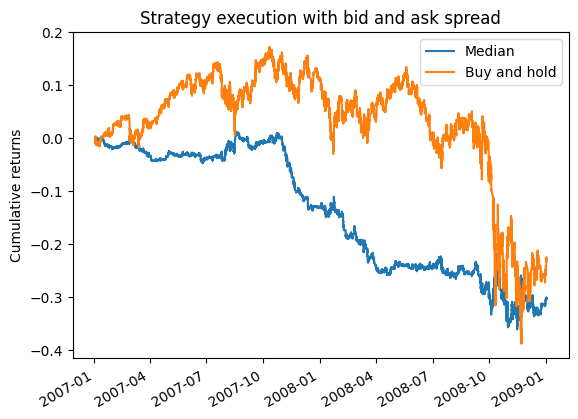

In [83]:
#_=strat_eval(pos, ret_vwap_common, Strat_Name='med')
cp1=strat_eval_bbo(pos, ret_bid_common, ret_ask_common, Strat_Name='Median')

T=int(np.floor(ret_bid_common.shape[1]/3))
posBH= pd.DataFrame(0.0, index=ret_ask_common.index, columns=ret_ask_common.columns)
posBH.iloc[T+1:]=1/ret_ask_common.shape[1]
cp2=strat_eval_bbo(posBH, ret_bid_common, ret_ask_common, Strat_Name='Buy and hold')


plt.xlabel('')
plt.ylabel('Cumulative returns')
plt.title(f'Strategy execution with bid and ask spread')
plt.legend()
plt.show()

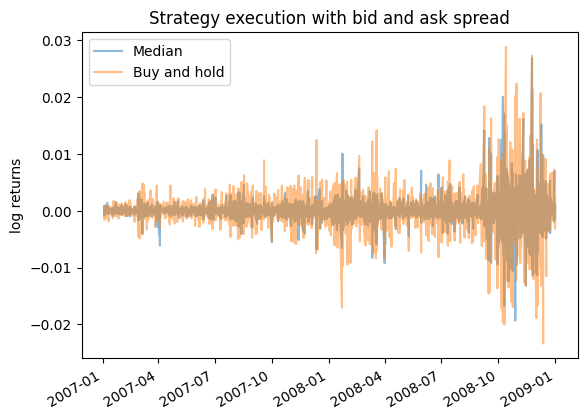

In [82]:
from cProfile import label


np.log(cp1).plot(label='Median', alpha=0.5)
np.log(cp2).plot(label='Buy and hold', alpha = 0.5)

plt.xlabel('')
plt.ylabel('log returns')
plt.title(f'Strategy execution with bid and ask spread')
plt.legend()
plt.show()